# Linear and Nonlinear Regression
## Eric Feigelson 
## Summer School in Statistics for Astronomers

**In this tutorial, we exercise two types of regression using R and its CRAN packages.  First, we consider cases where a global mathematical function is assumed to apply to the full dataset.  These include linear and nonlinear regression with options such as weighting my measurement errors and robust treatment of outliers.  A crucial aspect is goodness-of-fit and residual analysis to confirm that the best-fit model is indeed a good fit.  Second we consider several local regression methods where a continuous curve is estimated from sequential pieces of the data.**

## 1. Linear modeling

We start by running one of the most widely used functions in R, _lm_ for linear modeling, and related procedures. But vefore we start, it is important to note that, in statistical parlance, 'linear' refers to a much broader range of models than $Y = \beta_0 + \beta_1 X + \epsilon$.  It includes any model that is linear in the model **parameters**.  Thus the following models are 'linear' and an encompassed by the powerful theorems underlying linear modeling:
- $Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \epsilon$ (polynomial)
- $Y = \beta_0 e^{-X} + \epsilon$ (exponential)
- $Y = \beta_0 + \beta_1 sin X + \beta_2 cos X + \epsilon$ (sinusoid)

In contrast the following models are nonlinear:
- $Y = (X/\beta_0)^{-\beta_1}+ \epsilon$  power law (Pareto)
- $Y = \beta_0 e^{-X/\beta_1} + \epsilon$ (scaled exponential)
- $Y = \beta_0 / (1 + (X/\beta_1)^2) + \epsilon$  isothermal sphere
- $Y = \beta_0 + \beta_1 sin(X + \beta_2) + \beta_3 cos(X + \beta_2) + \epsilon$  sinusoid with arbitrary phase
- $Y = [\beta_0 + \beta_1 X for X < \beta_2] and [\beta_3 + \beta_4 X for X > \beta_2]$ segmented linear
- Most astrophysical models like $\Lambda$CDM cosmology 

We will practice linear modeling with a collection of photometry of spectroscopically confirmed quasars from the Sloan Digital Sky Sruvey.  We examine a relationship between the magnitdues in two bands; this is scientifically rather useless, but gives opportunity to test methodology for simple linear regression with difficulties common in astronomical regressions:  non-Gaussian scatter, heteroscedastic measurement errors, and outliers.  

Note that the theory of linear modeling is not restricted to bivariate problems: it is intrinsically multivariate in the sense that a single response variable $Y$ can be a function of a vector of covariates $\bf{X}$ as in the simple model: $Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_p X_p + \epsilon$.

In [4]:
# I. Construct large and small samples of 77K SDSS quasars

library("astrodatR")
data(SDSS_QSO)     # brings tabular data into an R data.frame

# Basic information about a data.frame
dim(SDSS_QSO)      # number of rows and columns
names(SDSS_QSO)    # names of columns
summary(SDSS_QSO)  # 5-number summary of each column

[1] 77429    15

[1] "SDSS"      "z"         "u_mag"     "sig_u_mag" "g_mag"     "sig_g_mag"
 [7] "r_mag"     "sig_r_mag" "i_mag"     "sig_i_mag" "z_mag"     "sig_z_mag"
[13] "FIRST"     "ROSAT"     "Mp"

                 SDSS             z              u_mag         sig_u_mag      
 000006.53+003055.2:    1   Min.   :0.0780   Min.   : 0.00   Min.   :0.00000  
 000008.13+001634.6:    1   1st Qu.:0.9555   1st Qu.:19.09   1st Qu.:0.02800  
 000009.26+151754.5:    1   Median :1.4820   Median :19.58   Median :0.03700  
 000009.38+135618.4:    1   Mean   :1.5375   Mean   :19.82   Mean   :0.08947  
 000009.42-102751.9:    1   3rd Qu.:1.9303   3rd Qu.:20.30   3rd Qu.:0.05500  
 000011.41+145545.6:    1   Max.   :5.4135   Max.   :26.79   Max.   :9.99900  
 (Other)           :77423                                                     
     g_mag         sig_g_mag           r_mag         sig_r_mag      
 Min.   : 0.00   Min.   :0.00000   Min.   : 0.00   Min.   :0.00000  
 1st Qu.:18.86   1st Qu.:0.01900   1st Qu.:18.69   1st Qu.:0.01700  
 Median :19.30   Median :0.02300   Median :19.12   Median :0.02000  
 Mean   :19.35   Mean   :0.02653   Mean   :19.12   Mean   :0.02238  
 3rd Qu.:19.95   3rd Qu

In [5]:
# Remove some bad photometry

qso <- SDSS_QSO[-which(SDSS_QSO[,3] == 0 | SDSS_QSO[,9] == 0),]
qso <- qso[-which(qso[,4] == 9.999 | qso[,12] == 9.999),]
qso[(qso[,4]<0.02),4 ] <- 0.02        # set threshold on magnitude errors
dim(qso) ; summary(qso)
attach(qso)

[1] 77290    15

                 SDSS             z              u_mag         sig_u_mag      
 000006.53+003055.2:    1   Min.   :0.0780   Min.   :15.40   Min.   :0.02000  
 000008.13+001634.6:    1   1st Qu.:0.9554   1st Qu.:19.09   1st Qu.:0.02800  
 000009.26+151754.5:    1   Median :1.4820   Median :19.59   Median :0.03700  
 000009.38+135618.4:    1   Mean   :1.5374   Mean   :19.85   Mean   :0.08954  
 000009.42-102751.9:    1   3rd Qu.:1.9300   3rd Qu.:20.30   3rd Qu.:0.05500  
 000011.41+145545.6:    1   Max.   :5.4135   Max.   :26.79   Max.   :9.41500  
 (Other)           :77284                                                     
     g_mag         sig_g_mag           r_mag         sig_r_mag      
 Min.   :15.32   Min.   :0.00800   Min.   :15.24   Min.   :0.00600  
 1st Qu.:18.86   1st Qu.:0.01900   1st Qu.:18.70   1st Qu.:0.01700  
 Median :19.31   Median :0.02300   Median :19.13   Median :0.02000  
 Mean   :19.38   Mean   :0.02658   Mean   :19.16   Mean   :0.02231  
 3rd Qu.:19.95   3rd Qu

When applied to a data.frame, the R function `attach` allows the user to access a column by its names (e.g. r_mag) without remembering their column number (e.g. qso[,3]).

Warning message:
"package 'KernSmooth' was built under R version 4.4.3"
KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009



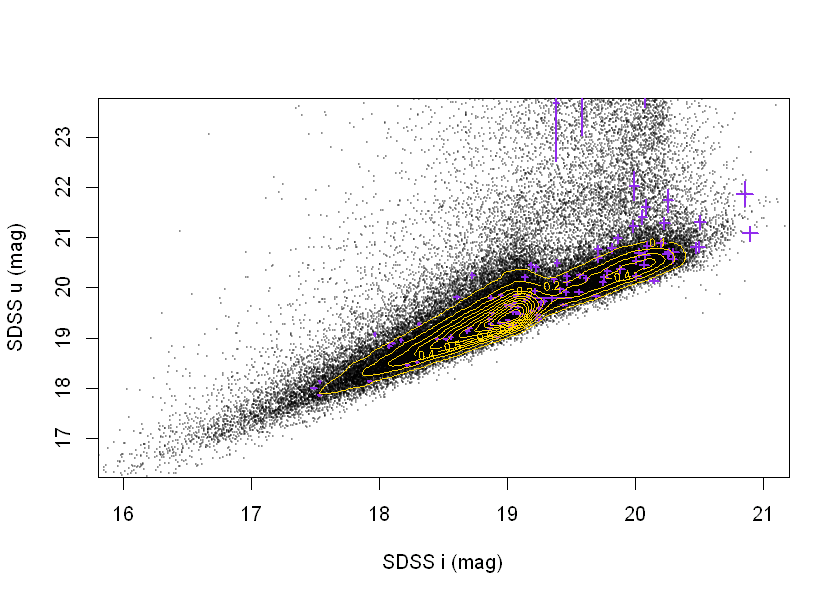

In [6]:
# Plot dataset of SDSS quasar i vs. u magnitudes showing 
# heteroscedastic measurement errors, with contours for dense regions

options(jupyter.plot_scale=1)
options(repr.plot.width = 7, repr.plot.height = 5)

plot(i_mag, u_mag, pch=20, cex=0.1, col='#00000040', xlim=c(16,21), 
   ylim=c(16.5,23.5), xlab="SDSS i (mag)", ylab="SDSS u (mag)")
for(i in 50:150) {
   lines(c(i_mag[i],i_mag[i]),c((u_mag[i]+sig_u_mag[i]),
      (u_mag[i]-sig_u_mag[i])), lwd=2, col='purple2')
   lines(c((i_mag[i]+sig_i_mag[i]),(i_mag[i]-sig_i_mag[i])),
      c(u_mag[i],u_mag[i]), lwd=2, col='purple2')   }

if(!require("KernSmooth", quietly=T)) {
  install.packages("KernSmooth", repos="https://cloud.r-project.org", dependencies=TRUE)
}; library("KernSmooth")
smqso <- bkde2D(cbind(i_mag, u_mag), bandwidth=c(0.05, 0.05), gridsize=c(400,400))
contour(smqso$x1, smqso$x2, smqso$fhat, add=T, col='gold', nlevels=9)

Here we see a disturbed dataset. There is wide asymmetrical scatter towards main magnitudes in the SDSS u (ultraviolet) band.  Much of the scatter is attributable to measurement errors, but not all of it. Let us now run _lm_ with the formula: $u = \beta_0 + \beta_1 i + \epsilon$, obtain 90% confidence interval of the intercept and slope parameters, and show the scatter plot with the fitted line. 


Call:
lm(formula = u_mag ~ i_mag)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.2093 -0.5097 -0.2849  0.0401  7.9862 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -3.784407   0.093357  -40.54   <2e-16 ***
i_mag        1.243705   0.004908  253.41   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.026 on 77288 degrees of freedom
Multiple R-squared:  0.4538,	Adjusted R-squared:  0.4538 
F-statistic: 6.422e+04 on 1 and 77288 DF,  p-value: < 2.2e-16


,5 %,95 %
(Intercept),-3.937967,-3.630846
i_mag,1.235632,1.251778


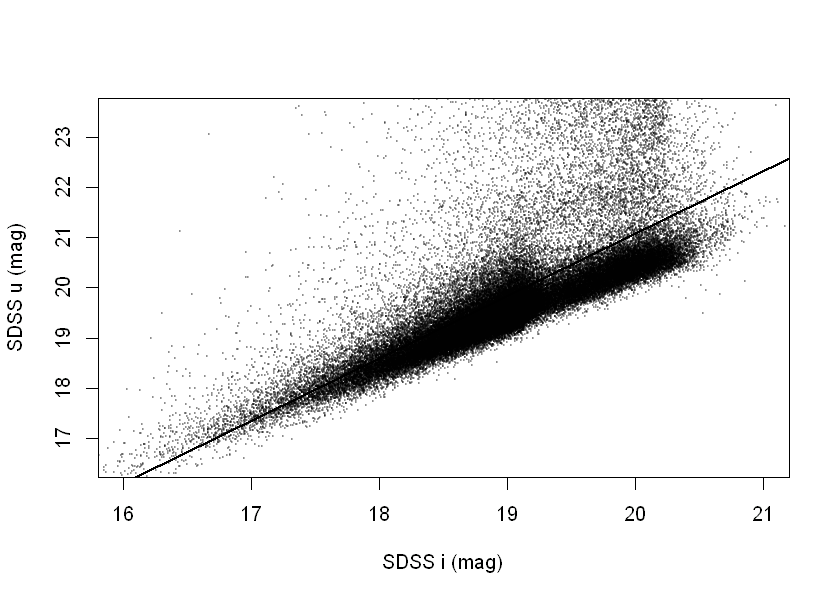

In [7]:
# II. Ordinary least squares fit

fit_ols <- lm(u_mag~i_mag)
summary(fit_ols) 
confint(fit_ols, level=0.90)          # 3 sigma equivalent for Gaussian distribution

plot(i_mag, u_mag, pch=20, cex=0.1, col='#00000040', xlim=c(16,21), 
   ylim=c(16.5,23.5), xlab="SDSS i (mag)", ylab="SDSS u (mag)")
abline(fit_ols$coef, lty=1, lwd=2)     # solid black line

Note that, since the scatter is non-Gaussian, the theorems underlying ordinary least squares means that the fit is not a maximum likelihood estimator and the parameter uncertainties may not be reliable.  Visually, this is a terrible fit, missing most of the data points.  We now try to improve it in three ways:  weighting by measurement errors; applying `robust` downweighting of outliers; and applying both corrections.  


Call:
lm(formula = u_mag ~ i_mag, weights = 1/(sig_u_mag * sig_u_mag), 
    x = T)

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-48.687  -3.757   1.266   6.281 120.471 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.220633   0.028881   42.26   <2e-16 ***
i_mag       0.960787   0.001555  618.03   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 9.066 on 77288 degrees of freedom
Multiple R-squared:  0.8317,	Adjusted R-squared:  0.8317 
F-statistic: 3.82e+05 on 1 and 77288 DF,  p-value: < 2.2e-16


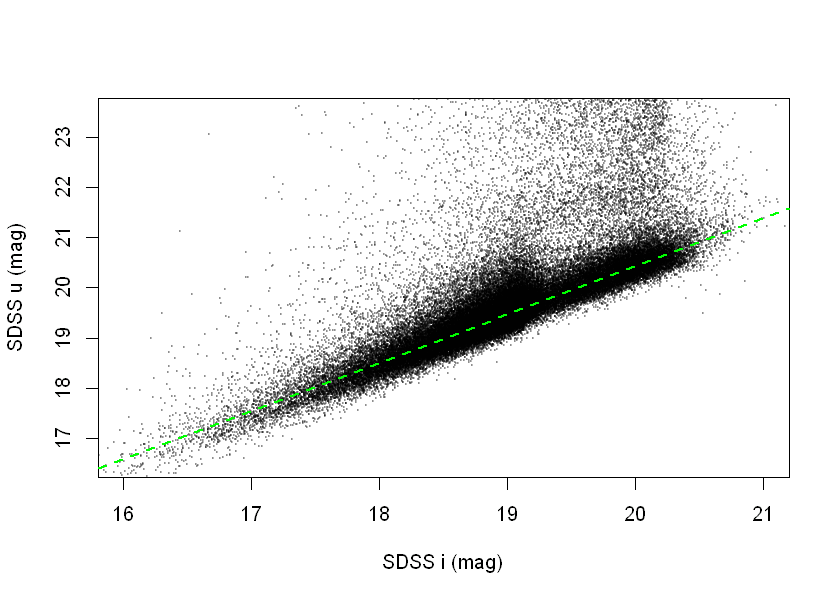

In [8]:
# III. Weighted least squares fit

fit_wt <- lm(u_mag~i_mag, x=T, weights=1/(sig_u_mag*sig_u_mag))
summary(fit_wt)

plot(i_mag, u_mag, pch=20, cex=0.1, col='#00000040', xlim=c(16,21), 
   ylim=c(16.5,23.5), xlab="SDSS i (mag)", ylab="SDSS u (mag)")
abline(fit_wt$coef,lty=2,lwd=2, col='green')    # dashed green line

This is the ***minimum chi-squared regression*** commonly used by astronomers; statisticians would call it ***weighted least squares regression with weights from heteroscedastic measurement errors***.  Here we see that most of the problems can be removed with measurement error weighting. However, the calculation is obviously wrong in this case because (in statistical parlance) the model is misspecified because only a portion of the scatter is caused by measurement error.  

Astronomers often do not carefully examine the accuracy and validity of their regression fits.  Diagnostic graphics are very useful for this.  Here are the plots produced automatically by R's `lm` function. For interpretation and details, see the text [_A Modern Approach to Regression with R_](https://link.springer.com/book/10.1007%2F978-0-387-09608-7) (S. Sheather, 2009).

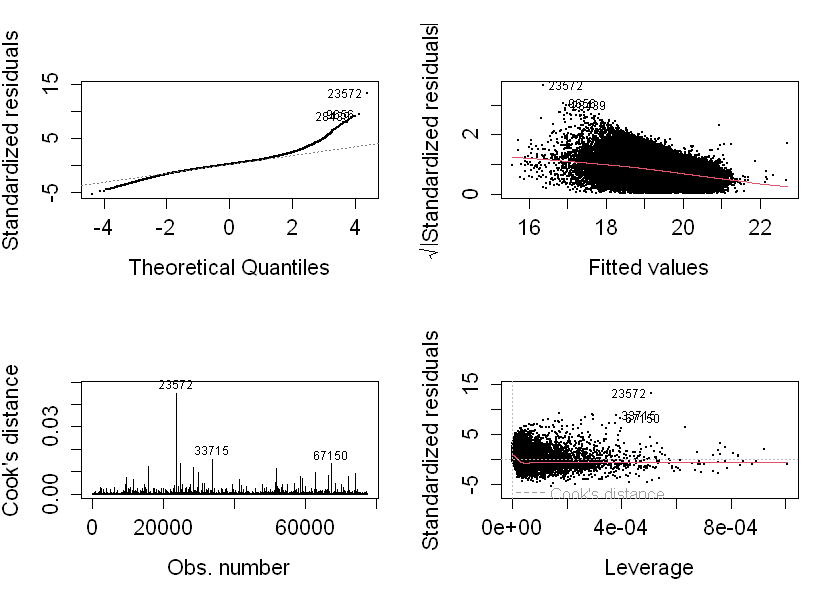

In [9]:
# Diagnostic plots involving regression residuals help identify outliers

par(mfrow=c(2,2))		
plot(fit_wt, which=c(2:5), caption='', sub.caption='' ,pch=20, cex=0.3, 
   cex.lab=1.3, cex.axis=1.3)

Other regression diagnostic tests can be applied to help evaluate the validity of the statistical model and its best-fit parameters.  The most important is a nonparametric two-sample test between the cumulative distribution functions of the observed and fitted values of the response variable. The Kolmogorov-Smirnov test is commonly used, but the Cramer-von Mises and Anderson-Darling tests are more sensitive.   However, theorems show that tabulated probabilities are inapplicable when the second distribution is from a model based on the first distribution.  We thus use bootstrap replications to estimate probabilities. This capability is provided by CRAN package 'cramer' for the Cramer-von Mises test.  To avoid excessive computational time, we only treat the first 1000 points here. The weighted linear fit is obviously rejected by the test.  


 1 -dimensional  nonparametric Cramer-Test with kernel phiCramer 
(on equality of two distributions) 

	x-sample:  1000  values        y-sample:  1000  values

critical value for confidence level  95 % :  1.428882 
observed statistic  17.41952 , so that
	 hypothesis ("x is distributed as y") is  REJECTED .
estimated p-value =  0 

	[result based on  100   ordinary  bootstrap-replicates]


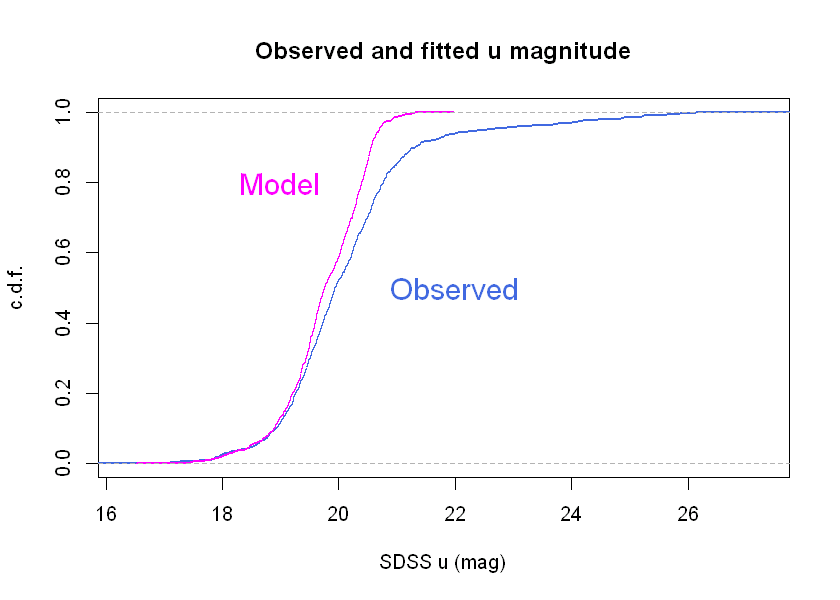

In [11]:
# Goodness-of-fit for a 2D regression
library("cramer")
cramer.test(fit_wt$model$u_mag[1:1000], fit_wt$fitted.values[1:1000], replicates=100)

plot(ecdf(fit_wt$model$u_mag[1:1000]), cex=0, col='royalblue', lwd=2, xlab='SDSS u (mag)', ylab='c.d.f.', main='Observed and fitted u magnitude')
plot(ecdf(fit_wt$fitted.values[1:1000]), cex=0, col='magenta', lwd=2, add=TRUE)
text(22, 0.5, 'Observed', cex=1.5, col='royalblue')
text(19, 0.8, 'Model', cex=1.5, col='magenta')

Another approach to non-Gaussianity and outliers is to apply _robust_ regression techniques.  These are many variants; here R's _rlm_ (robust linear modeling) function, downweighting outliers using Huber's psi function, with and without measurement error weighting.  Unfortunately, this code does not have a built-in line plotting option, so we draw the lines manually from information in the _rlm_ output.  See various approaches in R at the CRAN Task View on Robust Statistics.

Warning message:
"package 'MASS' was built under R version 4.4.3"



Call: rlm(formula = u_mag ~ i_mag, method = "M")
Residuals:
     Min       1Q   Median       3Q      Max 
-2.28936 -0.23476 -0.05688  0.23543  7.97974 

Coefficients:
            Value    Std. Error t value 
(Intercept)  -0.3093   0.0338    -9.1428
i_mag         1.0471   0.0018   588.8720

Residual standard error: 0.3484 on 77288 degrees of freedom


Call: rlm(formula = u_mag ~ i_mag, weights = 1/(sig_u_mag * sig_u_mag), 
    method = "M", wt.method = "inv.var")
Residuals:
    Min      1Q  Median      3Q     Max 
-49.653  -3.507   1.409   6.469 124.019 

Coefficients:
            Value    Std. Error t value 
(Intercept)   0.7889   0.0257    30.7415
i_mag         0.9832   0.0014   711.7537

Residual standard error: 7.511 on 77288 degrees of freedom

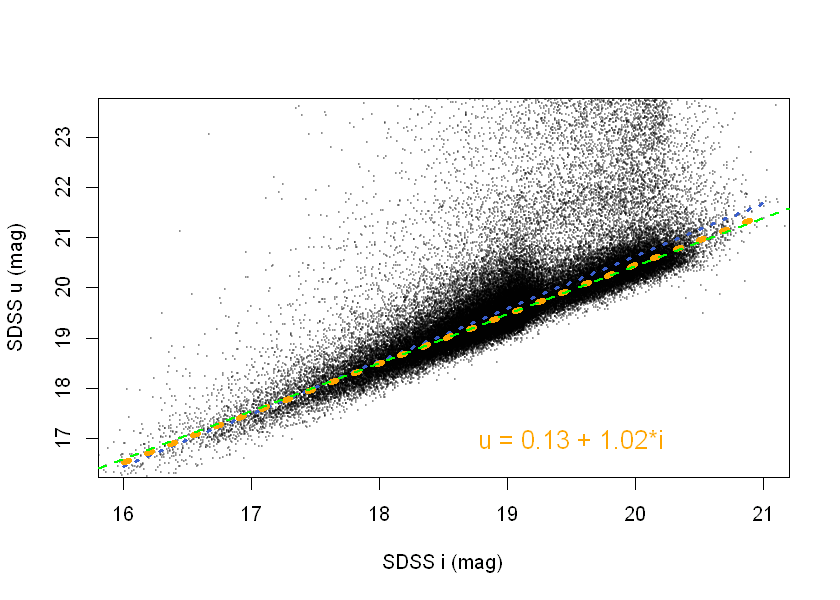

In [12]:
# Robust M-estimator

library(MASS)
fit_M <- rlm(u_mag~i_mag, method='M')	# robust fit with Huber's psi functon
summary(fit_M)  
aM <- fit_M$coef[[1]] ; bM <- fit_M$coef[[2]]

plot(i_mag, u_mag, pch=20, cex=0.1, col='#00000040', xlim=c(16,21), 
   ylim=c(16.5,23.5), xlab="SDSS i (mag)", ylab="SDSS u (mag)")
lines(c(16,21), c(aM+bM*16, aM+bM*21), lty=3, lwd=3, col='royalblue3') # dotted royal blue line

fit_Mwt <- rlm(u_mag~i_mag, method='M', weights=1/(sig_u_mag*sig_u_mag), 
   wt.method='inv.var')   # robust fit with measurement error weighting 
summary(fit_Mwt)  
aMwt <- fit_Mwt$coef[[1]] ; bMwt <- fit_Mwt$coef[[2]]

lines(c(16,21), c(aMwt+bMwt*16, aMwt+bMwt*21), lty=3, lwd=5, col='orange')
text(19.5, 17, 'u = 0.13 + 1.02*i', cex=1.3, col='orange')

abline(fit_wt$coef,lty=2,lwd=2, col='green')    # dashed green line (weighted LS fit)

Here we see that a robust regression line that downweights outliers treated most of the problem with bad u-band photometry.  And a line that treats ***both outliers and measurement errors*** did a great job (orange line).  This is probably the preferred result for this problem.  But of course, the model is misspecified as the residuals are far from homoscedastic Gaussian noise, so the scientific meaning of the result (slope = 1.02) is suspect. 


> **Exercise 1**.  Try different robustification options in _rlm_ such as MM estimation and different choices of removal of outlying points (options in _lqs_). 

### 2. Nonlinear regression

<center><img src="Ilc_9yr_moll4096.png" width=400>  <img src="587px-PowerSpectrumExt.svg.png" width=400></center>

Astronomers often fit data with nonlinear functions derived from astrophysical theory that we believe apply to the observed situation. Among important recent applications of nonlinear regression are the fitting of the consensus Lambda-CDM model of cosmology to the fluctuations in the cosmic microwave background (images above, WMAP results) and the fitting of Keplerian exoplanetary orbits to stellar radial velocity time series.  

But astronomers also often fit data with heuristic nonlinear functions that do not have a clear astrophysical interpretation such as the stellar Initial Mass Function (several distributions used), galaxy luminosity function (Schechter function = gamma distribution), Navarro-Frenk-White Dark Matter profile, and various galaxy scaling relations.

Here we fit radial profiles from nearby Virgo Cluster elliptical galaxies to a heuristic nonlinear function proposed by Jose Luis Sersic in 1968. Here the surface brightness $B$ of an elliptical galaxy (or spiral galaxy bulge) as a function of radius $r$ follows: $B \propto -2.5*log(I_e * 10^{-(0.868*n-0.142)}((r/r_e)^{1/n}-1))$.  The data are obtained from [Kormendy et al. 2009](https://ui.adsabs.harvard.edu/abs/2009ApJS..182..216K/abstract). We fit using R's _nls_ (nonlinear least squares) function;  see also CRAN package _nmle_ for maximum likelihood fitting.

In [13]:
# Unpack galaxy profile data

data(ell_gal_profile)
summary(ell_gal_profile)
NGC4472 <- ell_gal_profile[ell_gal_profile[,1] == 'NGC.4472',2:3]
NGC4472
radius <- NGC4472[,1]
surf_mag <- NGC4472[,2]

NGC4472.fit <-  nls(surf_mag ~ -2.5*log10(I.e * 10^(-(0.868*n-0.142)*
   ((radius/r.e)^{1/n}-1))) + 26, data=list(NGC4472), start=list(I.e=20.,
   r.e=120.,n=4.), model=T, trace=T)
summary(NGC4472.fit)
logLik(NGC4472.fit)


      galaxy       radius           surf_mag    
 NGC.4406:52   Min.   :  1.384   Min.   :16.32  
 NGC.4472:58   1st Qu.:  7.737   1st Qu.:18.51  
 NGC.4551:40   Median : 24.203   Median :20.08  
               Mean   : 75.963   Mean   :20.46  
               3rd Qu.: 76.949   3rd Qu.:22.03  
               Max.   :877.001   Max.   :27.32  

,radius,surf_mag
,<dbl>,<dbl>
1,3.526,16.917
2,4.015,17.032
3,4.557,17.150
4,4.966,17.239
5,5.491,17.339
6,6.039,17.439
7,6.572,17.531
8,7.244,17.639
9,7.822,17.723


Warning message in min(x):
"no non-missing arguments to min; returning Inf"
Warning message in max(x):
"no non-missing arguments to max; returning -Inf"


67.21708    (2.88e+01): par = (20 120 4)
3.648655    (6.76e+00): par = (19.00416 179.0912 5.211069)
3.016947    (6.13e+00): par = (11.14254 239.9565 5.833813)
0.08480302  (2.91e-01): par = (11.45163 265.4078 5.948181)
0.07817011  (2.08e-03): par = (11.40737 267.6302 5.952091)
0.07816977  (8.47e-08): par = (11.40733 267.6426 5.952099)



Formula: surf_mag ~ -2.5 * log10(I.e * 10^(-(0.868 * n - 0.142) * ((radius/r.e)^{
    1/n
} - 1))) + 26

Parameters:
     Estimate Std. Error t value Pr(>|t|)    
I.e  11.40733    0.57560   19.82   <2e-16 ***
r.e 267.64261    7.05769   37.92   <2e-16 ***
n     5.95210    0.09718   61.25   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.0377 on 55 degrees of freedom

Number of iterations to convergence: 5 
Achieved convergence tolerance: 8.474e-08


'log Lik.' 109.3717 (df=4)

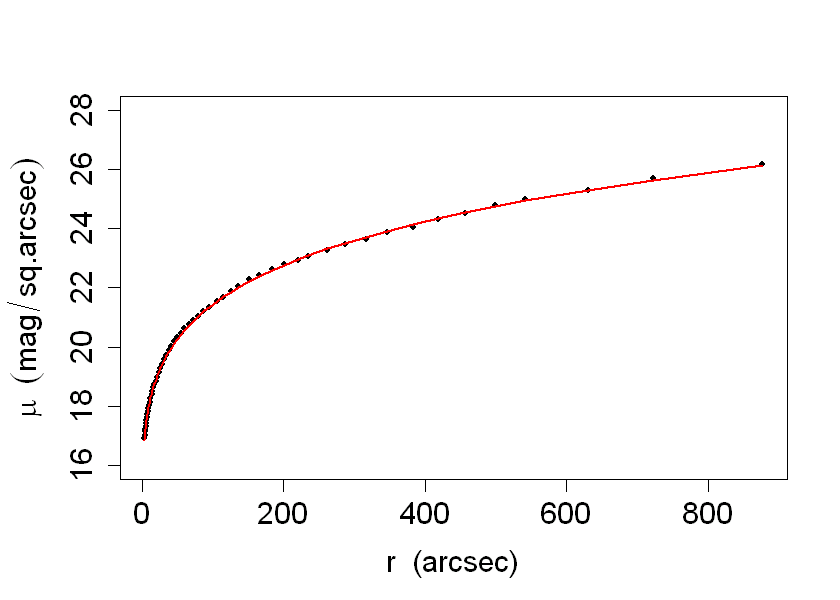

In [14]:
# Plot NGC 4472 data and best-fit model

par(mai=c(1,1,0.8,0.44))   # improve left-hand margin
plot(NGC4472.fit$model$radius, NGC4472.fit$model$surf_mag, pch=20, 
   xlab="r  (arcsec)", ylab=expression(mu ~~ (mag/sq.arcsec)), ylim=c(16,28), 
   cex.lab=1.5, cex.axis=1.5)
lines(NGC4472.fit$model$radius, fitted(NGC4472.fit), lw=2, col='red')

We can examine various scalar quantities from the _nls_ fit, and plot the residuals between the data and model.  A nonparametric smoother is added to assist seeing the amazing structure in the residuals: periodic shells of stars in excess of the monotonic Sersic model.  This is a well-known effect due to past galaxy mergers that form large elliptical galaxies. A similar residual plot appears in Kormendy's paper. 

In [15]:
# Details information about the nls fit

formula(NGC4472.fit)    # formula used
coef(NGC4472.fit)       # best-fit parameters
vcov(NGC4472.fit)       # best-fit parameter covariance matrix
logLik(NGC4472.fit)     # log-likelihood of best fit

surf_mag ~ -2.5 * log10(I.e * 10^(-(0.868 * n - 0.142) * ((radius/r.e)^{
    1/n
} - 1))) + 26

I.e        r.e          n 
 11.407328 267.642615   5.952099

,I.e,r.e,n
I.e,0.33131615,-4.0282859,-0.05221804
r.e,-4.02828586,49.8110277,0.61791631
n,-0.05221804,0.6179163,0.00944324


'log Lik.' 109.3717 (df=4)

In [16]:
confint(NGC4472.fit)    # 95% confidence intervals
profile(NGC4472.fit)    # profiles (cuts) around the best fit (unfortunately the console output is verbose here)

Waiting for profiling to be done...



0.1258499   (7.76e-01): par = (267.6426 5.952099)
0.07855497  (5.02e-03): par = (271.3052 5.999577)
0.07855299  (1.64e-06): par = (271.3336 5.999636)
0.07978523  (3.04e-02): par = (275.005 6.04692)
0.07971132  (1.85e-05): par = (275.1635 6.048316)
0.07971132  (2.92e-08): par = (275.1635 6.048319)
0.08172463  (3.11e-02): par = (278.9516 6.096472)
0.08164548  (2.57e-05): par = (279.1183 6.097914)
0.08164548  (1.40e-08): par = (279.1183 6.09792)
0.08444048  (3.16e-02): par = (283.0287 6.146965)
0.08435610  (3.30e-05): par = (283.2036 6.148453)
0.08435610  (1.01e-07): par = (283.2036 6.148461)
0.08793387  (3.20e-02): par = (287.242 6.198422)
0.08784386  (4.02e-05): par = (287.4256 6.199958)
0.08784386  (9.20e-08): par = (287.4255 6.199968)
0.1234279   (7.56e-01): par = (267.6426 5.952099)
0.07854678  (4.86e-03): par = (264.0742 5.905842)
0.07854493  (1.61e-06): par = (264.1009 5.905899)
0.07972825  (2.86e-02): par = (260.5404 5.859453)
0.07966293  (1.50e-05): par = (260.6812 5.860736)
0.07

,2.5%,97.5%
I.e,10.27796,12.584321
r.e,254.29016,282.671404
n,5.76343,6.153343


0.1291124   (8.02e-01): par = (267.6426 5.952099)
0.07858126  (5.36e-03): par = (271.4285 6.001174)
0.07857900  (1.79e-06): par = (271.4588 6.001237)
0.07990067  (3.25e-02): par = (275.254 6.050106)
0.07981626  (2.07e-05): par = (275.4235 6.051598)
0.07981626  (2.14e-08): par = (275.4235 6.051602)
0.08197297  (3.33e-02): par = (279.3436 6.101398)
0.08188238  (2.86e-05): par = (279.5221 6.102941)
0.08188238  (5.18e-08): par = (279.5221 6.102948)
0.08487488  (3.38e-02): par = (283.5732 6.153699)
0.08477808  (3.65e-05): par = (283.7609 6.155293)
0.08477808  (6.97e-08): par = (283.7609 6.155302)
0.08860763  (3.42e-02): par = (287.9492 6.207033)
0.08850413  (4.45e-05): par = (288.1466 6.208681)
0.08850413  (1.26e-07): par = (288.1466 6.208692)
0.1264410   (7.81e-01): par = (267.6426 5.952099)
0.07857222  (5.19e-03): par = (263.9574 5.904327)
0.07857010  (1.75e-06): par = (263.9858 5.904388)
0.07983718  (3.05e-02): par = (260.309 5.856415)
0.07976288  (1.67e-05): par = (260.459 5.857782)
0.0

$I.e
          tau par.vals.I.e par.vals.r.e par.vals.n
1  -2.6965213     9.899142   288.146574   6.208692
2  -2.1562899    10.194122   283.760882   6.155302
3  -1.6162253    10.492653   279.522145   6.102948
4  -1.0763218    10.794685   275.423545   6.051602
5  -0.5365917    11.100163   271.458795   6.001237
6   0.0000000    11.407328   267.642615   5.952099
7   0.5307306    11.714494   263.985829   5.904388
8   1.0587308    12.023345   260.459076   5.857778
9   1.5868740    12.335497   257.037637   5.811991
10  2.1151421    12.650899   253.717291   5.767006
11  2.6435313    12.969511   250.493934   5.722806
12  3.1720377    13.291291   247.363667   5.679372

$r.e
          tau par.vals.I.e par.vals.r.e par.vals.n
1  -2.7446486    13.014510   249.725368   5.723444
2  -2.1943315    12.685916   253.098154   5.767481
3  -1.6437865    12.360312   256.577765   5.812423
4  -1.0930108    12.037760   260.169087   5.858292
5  -0.5421435    11.718401   263.876325   5.905099
6   0.0000000    11.

In [0]:
fitted(NGC4472.fit)     # fitted values
residuals(NGC4472.fit)  # residuals from the fitted values

# Residual plot

plot(NGC4472.fit$model$radius,residuals(NGC4472.fit), xlab="r (arcsec)", 
   ylab="Residuals", pch=20, cex.lab=1.5, cex.axis=1.5)
lines(supsmu(NGC4472.fit$model$radius, residuals(NGC4472.fit), span=0.05), 
   lwd=2, col='red')

We can perform more analysis of the residuals.  First, we show the residuals are normally distributed (Shapiro-Wilks test) but exhibit strong spatial autocorrelation (Durbin-Watson test). 


	Shapiro-Wilk normality test

data:  residuals(NGC4472.fit)/summary(NGC4472.fit)$sigma
W = 0.97433, p-value = 0.255


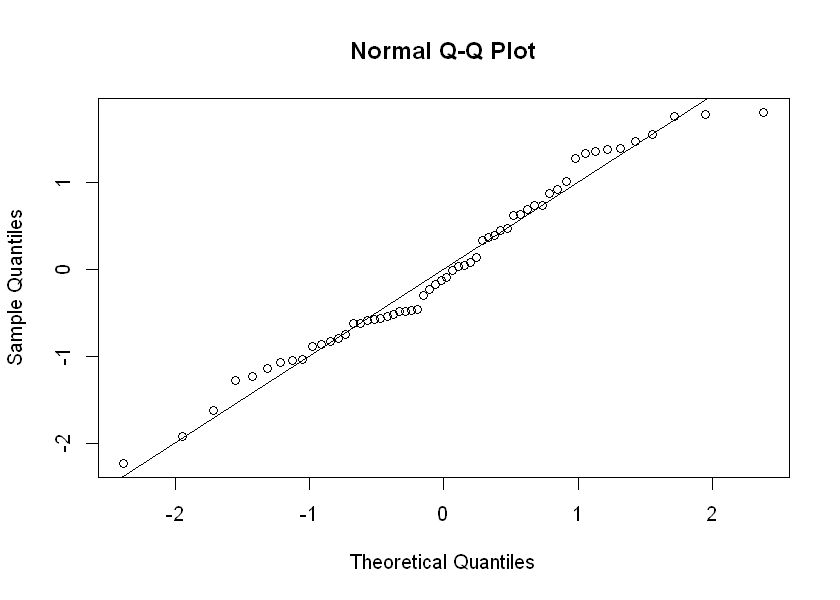

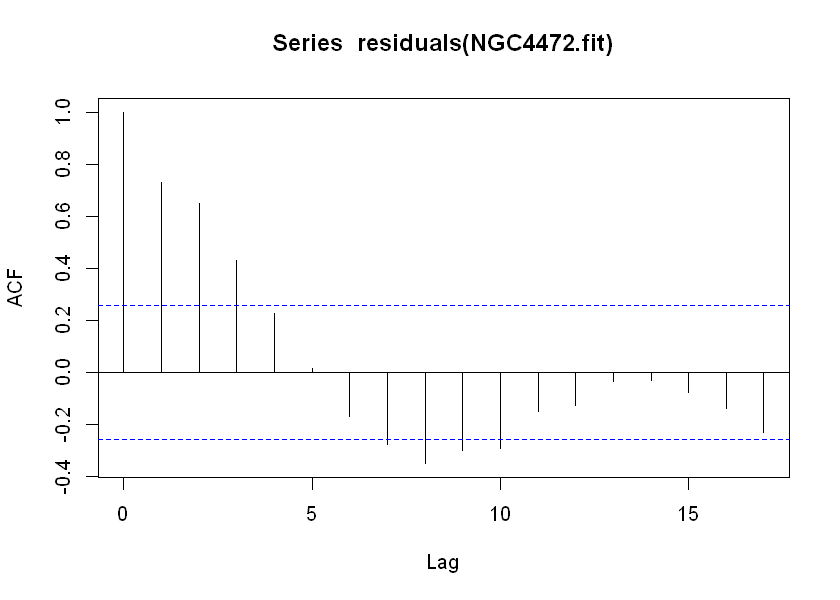

In [17]:
# Test for normality (OK) and autocorrelation (not OK) of residuals
# For linear models, also use the Durbin-Watson test in CRAN packages lmtest and car

qqnorm(residuals(NGC4472.fit) / summary(NGC4472.fit)$sigma) 
abline(a=0,b=1)
shapiro.test(residuals(NGC4472.fit) / summary(NGC4472.fit)$sigma) 
acf(residuals(NGC4472.fit))

There is an oddity: the error on Sersic's _n_ parameter from `nls` is much smaller than the error quoted by Kormendy.  Reading Kormendy's appendix, I find that he did not know how to evaluate the uncertainty of a nonlinear fit and chose an _ad hoc_ procedure that overestimated the error.  His estimate of _n_ was much more accurate than he thought.

> **Exercise 2.**  (a) See whether the best-fit model is significantly different using maximum likelihood estimation (CRAN package _nmle_) rather than Iteratively Weighted Least Squares (_nls_ in R).  (b) Estimate parameter confidence intervals using bootstrap techniques using CRAN _nlstools_.

### Some useful books for regression

- S. Sheather, [_A Modern Approach to Regression with R_](https://link.springer.com/book/10.1007%2F978-0-387-09608-7), 2009, Springer
- J. Fox, [_An R Companion to Applied Regression_](https://socialsciences.mcmaster.ca/jfox/Books/Companion/), 3rd ed, 2019, Sage 
- C. Ritz & J. Streibig, [_Nonlinear Regression with R_](https://link.springer.com/book/10.1007/978-0-387-09616-2), 2008, Springer
- K. Takezawa, [_Introduction to Nonparametric Regression_](https://onlinelibrary.wiley.com/doi/book/10.1002/0471771457), 2005, Wiley
- J. Harazlak, D. Ruppert & M. Wand, [_Semiparametric Regression with R_](https://link.springer.com/book/10.1007/978-1-4939-8853-2),  2018, Springer